<a href="https://colab.research.google.com/github/wasnaqvi/colab_notebooks/blob/main/Model_Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import annotations
import math
from typing import Dict, List, Iterable, Optional, Sequence
!pip install arviz
!pip install numpyro
import numpy as np
import pandas as pd


def _extract_names(df: pd.DataFrame, name_col: Optional[str]) -> List[str]:
    """
    Row-aligned extraction of planet names from df.

    If name_col is None or missing, falls back to "row_{i}".
    """
    if name_col is not None and name_col in df.columns:
        # make robust strings; preserve ordering aligned to df rows
        s = df[name_col].astype(str).fillna("")
        # optional: strip whitespace
        names = [x.strip() for x in s.to_list()]
        # if any are empty, replace those with row_i identifiers
        out: List[str] = []
        for i, nm in enumerate(names):
            out.append(nm if nm else f"row_{i}")
        return out

    # fallback: stable identifiers even if there is no name column
    return [f"row_{i}" for i in range(len(df))]



class Survey:
    """
    Survey
    ------
    A `Survey` represents *one sampled subset* of the parent Hermes dataset.

    Think of it as the atomic unit you fit models to:
      - It contains the DataFrame slice (`df`) that your model will ingest
      - It contains metadata about how it was drawn (survey_id, class_label)
      - NEW: it also carries planet/target names forward so you can:
          * inspect "what was actually sampled"
          * label/annotate plots per-survey
          * later overlay posterior predictive / fitted curves with planet names

    What is stored?
    ---------------
    Nothing permanent is written anywhere — names live only in-memory inside
    each Survey instance:

      - `planet_names`: list[str] aligned with df rows
      - `planet_index`: dict[str, list[int]] mapping name -> row indices
        (list because duplicates can happen; e.g., repeated identifiers)
    """

    def __init__(
        self,
        survey_id: int,
        class_label: str,
        df: pd.DataFrame,
        *,
        name_col: Optional[str] = None,
    ):
        self.survey_id = int(survey_id)
        self.class_label = str(class_label)
        self.df = df.reset_index(drop=True)

        # NEW: carry forward names (row-aligned)
        self.name_col = name_col if (name_col in self.df.columns) else None
        self.planet_names: List[str] = _extract_names(self.df, self.name_col)

        # NEW: quick lookup from name -> rows inside this survey
        self.planet_index: Dict[str, List[int]] = {}
        for i, nm in enumerate(self.planet_names):
            self.planet_index.setdefault(nm, []).append(i)

    @property
    def n(self) -> int:
        return len(self.df)

    # targets.

    def targets(self) -> List[str]:
        """Return the planet/target names in this survey (row-aligned)."""
        return list(self.planet_names)

    def target_table(self, cols: Optional[Sequence[str]] = None) -> pd.DataFrame:
        """
        Return a small inspection table with names + selected columns.

        """
        out = pd.DataFrame({"planet_name": self.planet_names})
        if cols:
            cols = [c for c in cols if c in self.df.columns]
            out = pd.concat([out, self.df.loc[:, cols].reset_index(drop=True)], axis=1)
        return out

    def row_for_target(self, name: str) -> List[int]:
        """Return row indices in `df` for a given target name (may be multiple)."""
        return self.planet_index.get(str(name), [])

    # leverage and metrics testing.
    def leverage(self, col: str = "logM") -> float:
        """
        Leverage of the specified column.
        Default: leverage of logM.
        1D leverage proxy:
        L = sqrt( sum_i (x_i - mean(x))^2 )
        computed on finite values only.

        Notes
        -----
        - This is essentially sqrt(n) * std(x).
        Grows with both spread and sample size.
        """
        arr = self.df[col].to_numpy(float)
        m = np.isfinite(arr)
        arr = arr[m]
        if arr.size < 2:
            return 0.0
        return float(np.sqrt(np.sum((arr - arr.mean()) ** 2)))

    def leverage_2D(self, col_x: str = "logM", col_y: str = "Star Metallicity") -> float:
        """
        2D leverage proxy as quadrature sum of 1D leverages.
        """
        return float(np.sqrt(self.leverage(col_x) ** 2 + self.leverage(col_y) ** 2))

    def leverage_3D(
        self,
        col_x: str = "logM",
        col_y: str = "Star Metallicity",
        col_z: str = "Planet Radius [Re]",
    ) -> float:
        return float(math.cbrt(self.leverage(col_x) ** 2 + self.leverage(col_y) ** 2 + self.leverage(col_z) ** 2))

    def mahalanobis_3D(
        self,
        col_x: str = "logM",
        col_y: str = "Star Metallicity",
        col_z: str = "Planet Radius [Re]",
    ) -> float:
        """
        Mean 3D Mahalanobis distance of points in the specified columns,
        computed within this survey.

        Returns 0 if there are <2 finite rows.
        """
        data = self.df[[col_x, col_y, col_z]].to_numpy(float)
        data = data[np.all(np.isfinite(data), axis=1)]
        if data.shape[0] < 2:
            return 0.0
        mean = np.mean(data, axis=0)
        cov = np.cov(data, rowvar=False)
        inv_cov = np.linalg.inv(cov)
        diff = data - mean
        m_dist = np.sqrt(np.einsum("ij,jk,ik->i", diff, inv_cov, diff))
        return float(np.mean(m_dist))


class SurveySampler:
    """
    SurveySampler
    -------------
    Builds nested mass classes (S1..S4) from HermesData and draws many Survey
    objects from them over an N-grid.

    Core idea:
      - HermesData is the "parent population" (your ARIEL MCS or synthetic set)
      - SurveySampler constructs *class-conditional subsets* (S1..S4)
      - sample_grid draws many Survey realizations without replacement
        for each (class, N) combination.

    NEW:
      - You can specify `name_col` (planet-name column) once in the sampler.
      - Each Survey produced will carry those names forward in-memory.

    Why this matters:
      - Compute survey-level metrics (leverage, WAIC diffs, etc.)
        and still have full traceability to the *exact targets* that drove
        that result.
    """

    def __init__(
        self,
        hermes: HermesData,
        rng_seed: Optional[int] = None,
        *,
        name_col: Optional[str] = None,
    ):
        self.hermes = hermes
        self.rng = np.random.default_rng(rng_seed)

        # NEW: choose / infer planet name column once (used for all surveys)
        if name_col is None:
            name_col ='Planet Name'
        self.name_col = name_col

        # build nested mass classes based on logM quantiles
        self.mass_classes: Dict[str, pd.DataFrame] = self._build_mass_classes()

    def _build_mass_classes(self) -> Dict[str, pd.DataFrame]:
        df = self.hermes.df
        q25, q50, q75 = df["logM"].quantile([0.25, 0.5, 0.75])

        classes: Dict[str, pd.DataFrame] = {}
        classes["S1"] = df.copy()
        classes["S2"] = df[df["logM"] >= q25].copy()
        classes["S3"] = df[df["logM"] >= q50].copy()
        classes["S4"] = df[df["logM"] >= q75].copy()
        return classes

    def sample_grid(
        self,
        N_grid: Iterable[int],
        n_reps_per_combo: int = 10,
        class_order: Optional[List[str]] = None,
    ) -> List[Survey]:
        """
        For each class in class_order and each N in N_grid,
        draw n_reps_per_combo surveys without replacement.

        Returns
        -------
        surveys : list[Survey]
            Flat list of Survey objects. Each Survey contains:
              - df: sampled targets
              - planet_names, planet_index: NEW traceability layer
        """
        if class_order is None:
            class_order = ["S1", "S2", "S3", "S4"]

        surveys: List[Survey] = []
        survey_id = 1

        for label in class_order:
            if label not in self.mass_classes:
                continue
            subset = self.mass_classes[label]
            n_available = len(subset)

            for N in N_grid:
                if N > n_available:
                    continue

                for _ in range(n_reps_per_combo):
                    rs = int(self.rng.integers(0, 2**32 - 1))
                    sample_df = subset.sample(n=N, replace=False, random_state=rs)
                    surveys.append(
                        Survey(
                            survey_id,
                            label,
                            sample_df,
                            name_col=self.name_col,
                        )
                    )
                    survey_id += 1

        return surveys


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 370.9/370.9 kB 30.0 MB/s eta 0:00:00


In [2]:
from __future__ import annotations
from dataclasses import asdict, dataclass
from multiprocessing import get_context
from typing import Any, Dict, List, Mapping, Optional, Sequence, Tuple, Union, Literal

import numpy as np
import numpy.typing as npt
import pandas as pd

import arviz as az
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.infer.util import log_likelihood



In [3]:
Array1D = npt.NDArray[np.floating]
ModelKind = Literal["lin", "met"]
JaxDType = Union[jnp.float32, jnp.float64]


def _as_1d_float(x: npt.ArrayLike) -> Array1D:
    return np.asarray(x, dtype=float).ravel()


def _finite_mask(*arrays: Array1D) -> npt.NDArray[np.bool_]:
    m = np.ones(arrays[0].shape, dtype=bool)
    for a in arrays:
        m &= np.isfinite(a)
    return m


def _safe_ptp(x: Array1D, fallback: float = 1.0) -> float:
    span = float(np.ptp(x))
    return span if np.isfinite(span) and span > 0.0 else float(fallback)


def _safe_sd(x: Array1D, fallback: float = 1.0) -> float:
    if x.size <= 1:
        return float(fallback)
    sd = float(np.std(x, ddof=1))
    return sd if np.isfinite(sd) and sd > 0.0 else float(fallback)


def _et68(x: np.ndarray) -> Tuple[float, float]:
    """
    Equal-tailed 68% interval (fast). (Not HDI!!)
    """
    lo, hi = np.quantile(x, [0.16, 0.84])
    return float(lo), float(hi)


def _scalar_stats_from_idata(idata: az.InferenceData, var: str) -> Dict[str, float]:
    """
    Fast scalar summaries from posterior samples:
      mean, sd, and equal-tailed 68% interval.
    """
    s = np.asarray(idata.posterior[var]).reshape(-1)
    mean = float(s.mean())
    sd = float(s.std(ddof=1)) if s.size > 1 else 0.0
    lo, hi = _et68(s)
    return {"mean": mean, "sd": sd, "hdi16": lo, "hdi84": hi}


# NUTS runner (compute log_likelihood only if you want the WAICs for Model comparison.
def _run_nuts(
    model_fn,
    rng_key: jax.Array,
    *,
    draws: int,
    tune: int,
    target_accept: float,
    num_chains: int,
    model_kwargs: Mapping[str, Any],
    compute_log_lik: bool,
    chain_method: Literal["parallel", "vectorized", "sequential"] = "sequential",
) -> Tuple[MCMC, Optional[Dict[str, jax.Array]]]:
    kernel = NUTS(model_fn, target_accept_prob=float(target_accept))
    mcmc = MCMC(
        kernel,
        num_warmup=int(tune),
        num_samples=int(draws),
        num_chains=int(num_chains),
        chain_method=chain_method,
        progress_bar=False,
    )
    mcmc.run(rng_key, **model_kwargs)

    if not compute_log_lik:
        return mcmc, None

    posterior = mcmc.get_samples(group_by_chain=True)
    ll = log_likelihood(model_fn, posterior, **model_kwargs)
    return mcmc, ll


# ----------------------------
# 1) Linear + intrinsic scatter (1D Model)
# ----------------------------
def _linear_scatter_model(
    *,
    x_c: jax.Array,                 # (N,)
    meas_sigma: jax.Array,          # (N,)
    y_obs: Optional[jax.Array],     # (N,)
    alpha_mu: float,
    alpha_sigma: float,
    beta_sigma: float,
    epsilon_sigma: float,
) -> None:
    alpha = numpyro.sample("alpha", dist.Normal(alpha_mu, alpha_sigma))
    beta = numpyro.sample("beta", dist.Normal(0.0, beta_sigma))
    epsilon = numpyro.sample("epsilon", dist.HalfNormal(epsilon_sigma))

    alpha_b = alpha[..., None]
    beta_b = beta[..., None]
    eps_b = epsilon[..., None]

    mu = alpha_b + beta_b * x_c
    obs_sigma = jnp.sqrt(meas_sigma**2 + eps_b**2)

    numpyro.sample("y", dist.Normal(mu, obs_sigma), obs=y_obs)


def _fit_leverage_survey_numpyro(
    x: npt.ArrayLike,
    y_obs: npt.ArrayLike,
    y_err_low: npt.ArrayLike,
    y_err_high: npt.ArrayLike,
    *,
    cfg: "ModelConfig",
    random_seed: int,
) -> az.InferenceData:
    x_np = _as_1d_float(x)
    y_np = _as_1d_float(y_obs)
    el_np = _as_1d_float(y_err_low)
    eh_np = _as_1d_float(y_err_high)

    m = _finite_mask(x_np, y_np, el_np, eh_np)
    if int(m.sum()) == 0:
        raise ValueError("No finite rows after filtering.")

    x_np, y_np, el_np, eh_np = x_np[m], y_np[m], el_np[m], eh_np[m]

    meas_sigma_np = 0.5 * (np.abs(el_np) + np.abs(eh_np))
    meas_sigma_np = np.clip(meas_sigma_np, 1e-6, None)

    x_c_np = x_np - float(x_np.mean())

    span_x = _safe_ptp(x_c_np, fallback=1.0)
    span_y = _safe_ptp(y_np, fallback=1.0)
    y_sd = _safe_sd(y_np, fallback=1.0)

    alpha_mu = float(y_np.mean())
    alpha_sigma = max(float(y_sd / np.sqrt(y_np.size)), 1e-3)
    beta_sigma = max(float(span_y / span_x), 1e-3)
    epsilon_sigma = max(float(y_sd), 1e-3)

    dtype = cfg.jax_dtype

    model_kwargs: Dict[str, Any] = dict(
        x_c=jnp.asarray(x_c_np, dtype=dtype),
        meas_sigma=jnp.asarray(meas_sigma_np, dtype=dtype),
        y_obs=jnp.asarray(y_np, dtype=dtype),
        alpha_mu=alpha_mu,
        alpha_sigma=alpha_sigma,
        beta_sigma=beta_sigma,
        epsilon_sigma=epsilon_sigma,
    )

    rng_key = jax.random.PRNGKey(int(random_seed))
    mcmc, ll = _run_nuts(
        _linear_scatter_model,
        rng_key,
        draws=cfg.draws,
        tune=cfg.tune,
        target_accept=cfg.target_accept,
        num_chains=cfg.num_chains,
        model_kwargs=model_kwargs,
        compute_log_lik=cfg.compute_log_lik,
        chain_method=cfg.chain_method,
    )

    return az.from_numpyro(mcmc, log_likelihood=ll) if ll is not None else az.from_numpyro(mcmc)


# -----------------------------------------
# 2) Metallicity model: y on logM and [Fe/H] (3D Model)
# -----------------------------------------
def _met_model(
    *,
    x_m_c: jax.Array,               # (N,) mass centered: (m - mean_mass)
    x_s_obs: jax.Array,             # (N,) observed stellar metallicity
    sig_meas_p: jax.Array,          # (N,) planetary metallicity measurement sigma
    sig_meas_s: jax.Array,          # (N,) stellar metallicity measurement sigma
    y_planet: Optional[jax.Array],  # (N,) planetary metallicity (e.g., log_x_h2o proxy)
    alpha_p_mu: float,
    alpha_p_sigma: float,
    beta_p_sigma: float,
    beta_s_sigma: float,
    epsilon_p_sigma: float,
) -> None:
    # latent true stellar metallicity
    x_s_true = numpyro.sample("x_s_true", dist.Normal(x_s_obs, sig_meas_s))

    # center stellar metallicity (using latent mean; batching-safe)
    x_s_true_c = x_s_true - jnp.mean(x_s_true, axis=-1, keepdims=True)

    # priors
    alpha_p = numpyro.sample("alpha_p", dist.Normal(alpha_p_mu, alpha_p_sigma))
    beta_p  = numpyro.sample("beta_p",  dist.Normal(0.0, beta_p_sigma))
    beta_s  = numpyro.sample("beta_s",  dist.Normal(0.0, beta_s_sigma))

    epsilon_p = numpyro.sample("epsilon", dist.HalfNormal(epsilon_p_sigma))
    numpyro.deterministic("sigma_p", epsilon_p)

    # broadcast scalars across N
    alpha_b = alpha_p[..., None]
    beta_p_b = beta_p[..., None]
    beta_s_b = beta_s[..., None]
    eps_b = epsilon_p[..., None]

    # THE science equation: planetary metallicity ~ mass + stellar metallicity
    mu_planetary_metallicity = alpha_b + beta_p_b * x_m_c + beta_s_b * x_s_true_c
    numpyro.deterministic("mu_planetary_metallicity", mu_planetary_metallicity)

    obs_sigma = jnp.sqrt(sig_meas_p**2 + eps_b**2)

    numpyro.sample("y_planet", dist.Normal(mu_planetary_metallicity, obs_sigma), obs=y_planet)


def _fit_met_survey_numpyro(
    x_mass: npt.ArrayLike,
    x_star: npt.ArrayLike,
    y_planet: npt.ArrayLike,
    y_planet_err_low: npt.ArrayLike,
    y_planet_err_high: npt.ArrayLike,
    x_star_err_low: npt.ArrayLike,
    x_star_err_high: npt.ArrayLike,
    *,
    cfg: "ModelConfig",
    random_seed: int,
) -> az.InferenceData:
    x_m = _as_1d_float(x_mass)
    x_s_obs = _as_1d_float(x_star)
    yp = _as_1d_float(y_planet)

    el_p = _as_1d_float(y_planet_err_low)
    eh_p = _as_1d_float(y_planet_err_high)
    el_s = _as_1d_float(x_star_err_low)
    eh_s = _as_1d_float(x_star_err_high)

    m = _finite_mask(x_m, x_s_obs, yp, el_p, eh_p, el_s, eh_s)
    x_m, x_s_obs, yp, el_p, eh_p, el_s, eh_s = (
        x_m[m], x_s_obs[m], yp[m], el_p[m], eh_p[m], el_s[m], eh_s[m]
    )

    if x_m.size == 0:
        raise ValueError("No finite rows for metallicity model in this survey.")

    sig_meas_p_np = 0.5 * (np.abs(el_p) + np.abs(eh_p))
    sig_meas_s_np = 0.5 * (np.abs(el_s) + np.abs(eh_s))
    sig_meas_p_np = np.clip(sig_meas_p_np, 1e-6, None)
    sig_meas_s_np = np.clip(sig_meas_s_np, 1e-6, None)

    x_m_c_np = x_m - float(x_m.mean())
    x_s_c_obs_np = x_s_obs - float(x_s_obs.mean())  # only for prior scaling

    span_xm = _safe_ptp(x_m_c_np, fallback=1.0)
    span_xs = _safe_ptp(x_s_c_obs_np, fallback=1.0)
    span_yp = _safe_ptp(yp, fallback=1.0)
    yp_sd = _safe_sd(yp, fallback=1.0)

    alpha_mu = float(yp.mean())
    alpha_sigma = max(float(yp_sd / np.sqrt(yp.size)), 1e-3)

    beta_m_sigma = max(float(span_yp / span_xm), 1e-3)
    beta_s_sigma = max(float(span_yp / span_xs), 1e-3)
    epsilon_sigma = max(float(yp_sd), 1e-3)

    dtype = cfg.jax_dtype

    model_kwargs: Dict[str, Any] = dict(
        x_m_c=jnp.asarray(x_m_c_np, dtype=dtype),
        x_s_obs=jnp.asarray(x_s_obs, dtype=dtype),
        sig_meas_p=jnp.asarray(sig_meas_p_np, dtype=dtype),
        sig_meas_s=jnp.asarray(sig_meas_s_np, dtype=dtype),
        y_planet=jnp.asarray(yp, dtype=dtype),
        alpha_p_mu=alpha_mu,
        alpha_p_sigma=alpha_sigma,
        beta_p_sigma=beta_m_sigma,   # same heuristic scale as before, just renamed
        beta_s_sigma=beta_s_sigma,
        epsilon_p_sigma=epsilon_sigma,
    )

    rng_key = jax.random.PRNGKey(int(random_seed))
    mcmc, ll = _run_nuts(
        _met_model,
        rng_key,
        draws=cfg.draws,
        tune=cfg.tune,
        target_accept=cfg.target_accept,
        num_chains=cfg.num_chains,
        model_kwargs=model_kwargs,
        compute_log_lik=cfg.compute_log_lik,
        chain_method=cfg.chain_method,
    )

    return az.from_numpyro(mcmc, log_likelihood=ll) if ll is not None else az.from_numpyro(mcmc)


# -------------------------
# Config + parallel helper
# -------------------------
@dataclass(frozen=True, slots=True)
class ModelConfig:
    draws: int = 1200
    tune: int = 400
    target_accept: float = 0.85
    num_chains: int = 1
    compute_log_lik: bool = False
    chain_method: Literal["parallel", "vectorized", "sequential"] = "sequential"
    jax_dtype: JaxDType = jnp.float32


def _fit_one_job(job: Tuple[ModelKind, Dict[str, Any], Survey, int]) -> Dict[str, Any]:
    """
    Module-level for multiprocessing spawn pickling.
    """
    kind, cfg_dict, survey, seed = job
    cfg = ModelConfig(**cfg_dict)

    if kind == "lin":
        idata = _fit_leverage_survey_numpyro(
            survey.df["logM"].to_numpy(),
            survey.df["log(X_H2O)"].to_numpy(),
            survey.df["uncertainty_lower"].to_numpy(),
            survey.df["uncertainty_upper"].to_numpy(),
            cfg=cfg,
            random_seed=int(seed),
        )
        a = _scalar_stats_from_idata(idata, "alpha")
        b = _scalar_stats_from_idata(idata, "beta")
        e = _scalar_stats_from_idata(idata, "epsilon")
        return {
            "survey_id": survey.survey_id,
            "class_label": survey.class_label,
            "N": survey.n,
            "L_met": float(survey.leverage(col="log(X_H2O)")),
            "L_logM": float(survey.leverage(col="logM")),
            "alpha_mean": a["mean"], "alpha_sd": a["sd"], "alpha_hdi16": a["hdi16"], "alpha_hdi84": a["hdi84"],
            "beta_mean":  b["mean"], "beta_sd":  b["sd"], "beta_hdi16":  b["hdi16"], "beta_hdi84":  b["hdi84"],
            "sigma_mean": e["mean"], "sigma_sd": e["sd"], "sigma_hdi16": e["hdi16"], "sigma_hdi84": e["hdi84"],
        }

    # kind == "met"
    idata = _fit_met_survey_numpyro(
        survey.df["logM"].to_numpy(),
        survey.df["Star Metallicity"].to_numpy(),
        survey.df["log(X_H2O)"].to_numpy(),
        survey.df["uncertainty_lower"].to_numpy(),
        survey.df["uncertainty_upper"].to_numpy(),
        survey.df["Star Metallicity Error Lower"].to_numpy(),
        survey.df["Star Metallicity Error Upper"].to_numpy(),
        cfg=cfg,
        random_seed=int(seed),
    )
    # FIXED: Extract the correct parameter names
    a = _scalar_stats_from_idata(idata, "alpha_p")
    bp = _scalar_stats_from_idata(idata, "beta_p")
    bs = _scalar_stats_from_idata(idata, "beta_s")
    e = _scalar_stats_from_idata(idata, "epsilon")

    return {
        "survey_id": survey.survey_id,
        "class_label": survey.class_label,
        "N": survey.n,
        "L_met": float(survey.leverage(col="log(X_H2O)")),
        "L_logM": float(survey.leverage(col="logM")),
        "alpha_p_mean": a["mean"], "alpha_p_sd": a["sd"], "alpha_p_hdi16": a["hdi16"], "alpha_p_hdi84": a["hdi84"],
        "beta_p_mean": bp["mean"], "beta_p_sd": bp["sd"], "beta_p_hdi16": bp["hdi16"], "beta_p_hdi84": bp["hdi84"],
        "beta_s_mean": bs["mean"], "beta_s_sd": bs["sd"], "beta_s_hdi16": bs["hdi16"], "beta_s_hdi84": bs["hdi84"],
        "epsilon_mean": e["mean"], "epsilon_sd": e["sd"], "epsilon_hdi16": e["hdi16"], "epsilon_hdi84": e["hdi84"],
    }


# -------------------------
# Public API: Model classes
# -------------------------
class Model:
    """
    1D Model: Planetary Metallicity ~ Mass only

    Fast NumPyro/JAX linear + intrinsic scatter model.

    Model equation:
        y_planet ~ Normal(alpha + beta * (mass - mean_mass), sqrt(sigma_meas^2 + epsilon^2))

    Defaults are tuned for speed (CPU-friendly).
    Set compute_log_lik=True only when you need WAIC/LOO.
    """

    def __init__(
        self,
        draws: int = 1200,
        tune: int = 400,
        target_accept: float = 0.85,
        num_chains: int = 1,
        compute_log_lik: bool = False,
        chain_method: Literal["parallel", "vectorized", "sequential"] = "sequential",
        jax_dtype: JaxDType = jnp.float32,
    ) -> None:
        self.cfg = ModelConfig(
            draws=int(draws),
            tune=int(tune),
            target_accept=float(target_accept),
            num_chains=int(num_chains),
            compute_log_lik=bool(compute_log_lik),
            chain_method=chain_method,
            jax_dtype=jax_dtype,
        )

    def fit_survey(self, survey: Survey, random_seed: int = 14) -> az.InferenceData:
        df = survey.df
        return _fit_leverage_survey_numpyro(
            df["logM"].to_numpy(),
            df["log(X_H2O)"].to_numpy(),
            df["uncertainty_lower"].to_numpy(),
            df["uncertainty_upper"].to_numpy(),
            cfg=self.cfg,
            random_seed=int(random_seed),
        )

    def summarize_single(self, survey: Survey, idata: az.InferenceData) -> Dict[str, Any]:
        a = _scalar_stats_from_idata(idata, "alpha")
        b = _scalar_stats_from_idata(idata, "beta")
        e = _scalar_stats_from_idata(idata, "epsilon")

        return {
            "survey_id": survey.survey_id,
            "class_label": survey.class_label,
            "N": survey.n,
            "L_met": float(survey.leverage(col="log(X_H2O)")),
            "L_logM": float(survey.leverage(col="logM")),
            "alpha_mean": a["mean"], "alpha_sd": a["sd"], "alpha_hdi16": a["hdi16"], "alpha_hdi84": a["hdi84"],
            "beta_mean":  b["mean"], "beta_sd":  b["sd"], "beta_hdi16":  b["hdi16"], "beta_hdi84":  b["hdi84"],
            "sigma_mean": e["mean"], "sigma_sd": e["sd"], "sigma_hdi16": e["hdi16"], "sigma_hdi84": e["hdi84"],
        }

    def run_on_surveys(
        self,
        surveys: Sequence[Survey],
        seed: int = 123,
        *,
        parallel: bool = False,
        processes: int = 4,
    ) -> pd.DataFrame:
        rng = np.random.default_rng(int(seed))

        if not parallel:
            rows: List[Dict[str, Any]] = []
            for survey in surveys:
                rs = int(rng.integers(0, 2**32 - 1))
                idata = self.fit_survey(survey, random_seed=rs)
                rows.append(self.summarize_single(survey, idata))
            return pd.DataFrame(rows).sort_values("survey_id").reset_index(drop=True)

        jobs: List[Tuple[ModelKind, Dict[str, Any], Survey, int]] = [
            ("lin", asdict(self.cfg), survey, int(rng.integers(0, 2**32 - 1)))
            for survey in surveys
        ]
        ctx = get_context("spawn")  # macOS safe
        with ctx.Pool(processes=int(processes)) as pool:
            rows = pool.map(_fit_one_job, jobs)

        return pd.DataFrame(rows).sort_values("survey_id").reset_index(drop=True)


class MetModel:
    """
    3D Model: Planetary Metallicity ~ Mass + Stellar Metallicity

    Fast NumPyro/JAX metallicity model with latent true stellar metallicity.

    Model equation:
        x_s_true ~ Normal(x_s_obs, sigma_s_meas)  # Latent true stellar metallicity
        y_planet ~ Normal(alpha_p + beta_p * (mass - mean_mass) + beta_s * (x_s_true - mean_x_s_true),
                          sqrt(sigma_meas^2 + epsilon^2))

    Defaults are tuned for speed (CPU-friendly).
    Set compute_log_lik=True only when you need WAIC/LOO.
    """

    def __init__(
        self,
        draws: int = 1200,
        tune: int = 400,
        target_accept: float = 0.85,
        num_chains: int = 1,
        compute_log_lik: bool = False,
        chain_method: Literal["parallel", "vectorized", "sequential"] = "sequential",
        jax_dtype: JaxDType = jnp.float32,
    ) -> None:
        self.cfg = ModelConfig(
            draws=int(draws),
            tune=int(tune),
            target_accept=float(target_accept),
            num_chains=int(num_chains),
            compute_log_lik=bool(compute_log_lik),
            chain_method=chain_method,
            jax_dtype=jax_dtype,
        )

    def fit_survey(self, survey: Survey, random_seed: int = 14) -> az.InferenceData:
        df = survey.df
        return _fit_met_survey_numpyro(
            df["logM"].to_numpy(),
            df["Star Metallicity"].to_numpy(),
            df["log(X_H2O)"].to_numpy(),
            df["uncertainty_lower"].to_numpy(),
            df["uncertainty_upper"].to_numpy(),
            df["Star Metallicity Error Lower"].to_numpy(),
            df["Star Metallicity Error Upper"].to_numpy(),
            cfg=self.cfg,
            random_seed=int(random_seed),
        )

    def summarize_single(self, survey: Survey, idata: az.InferenceData) -> Dict[str, Any]:
        # FIXED: Extract correct parameter names
        a  = _scalar_stats_from_idata(idata, "alpha_p")
        bp = _scalar_stats_from_idata(idata, "beta_p")
        bs = _scalar_stats_from_idata(idata, "beta_s")
        e  = _scalar_stats_from_idata(idata, "epsilon")

        return {
            "survey_id": survey.survey_id,
            "class_label": survey.class_label,
            "N": survey.n,
            "L_met": float(survey.leverage(col="log(X_H2O)")),
            "L_logM": float(survey.leverage(col="logM")),
            "alpha_p_mean": a["mean"], "alpha_p_sd": a["sd"], "alpha_p_hdi16": a["hdi16"], "alpha_p_hdi84": a["hdi84"],
            "beta_p_mean": bp["mean"], "beta_p_sd": bp["sd"], "beta_p_hdi16": bp["hdi16"], "beta_p_hdi84": bp["hdi84"],
            "beta_s_mean": bs["mean"], "beta_s_sd": bs["sd"], "beta_s_hdi16": bs["hdi16"], "beta_s_hdi84": bs["hdi84"],
            "epsilon_mean": e["mean"], "epsilon_sd": e["sd"], "epsilon_hdi16": e["hdi16"], "epsilon_hdi84": e["hdi84"],
        }

    def run_on_surveys(
        self,
        surveys: Sequence[Survey],
        seed: int = 321,
        *,
        parallel: bool = False,
        processes: int = 4,
    ) -> pd.DataFrame:
        rng = np.random.default_rng(int(seed))

        if not parallel:
            rows: List[Dict[str, Any]] = []
            for survey in surveys:
                rs = int(rng.integers(0, 2**32 - 1))
                idata = self.fit_survey(survey, random_seed=rs)
                rows.append(self.summarize_single(survey, idata))
            return pd.DataFrame(rows).sort_values("survey_id").reset_index(drop=True)

        jobs: List[Tuple[ModelKind, Dict[str, Any], Survey, int]] = [
            ("met", asdict(self.cfg), survey, int(rng.integers(0, 2**32 - 1)))
            for survey in surveys
        ]
        ctx = get_context("spawn")  # macOS safe
        with ctx.Pool(processes=int(processes)) as pool:
            rows = pool.map(_fit_one_job, jobs)

        return pd.DataFrame(rows).sort_values("survey_id").reset_index(drop=True)



In [4]:
# ====== 0) Setup ======
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import arviz as az
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.infer.util import log_likelihood

# Nice readable plots
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "font.size": 12
})

# Global determinism
GLOBAL_SEED = 123
np.random.seed(GLOBAL_SEED)

# ArviZ config
az.rcParams["stats.hdi_prob"] = 0.68
az.rcParams["plot.max_subplots"] = 50

print("numpyro:", numpyro.__version__)
print("jax:", jax.__version__)


numpyro: 0.19.0
jax: 0.7.2


/usr/local/lib/python3.12/dist-packages/arviz/rcparams.py:345: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


In [5]:
CSV_PATH = "hermes_synthetic_data_0.2.0.csv"
df = pd.read_csv(CSV_PATH).replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)

class HermesData:
    def __init__(self, df):
        self.df = df

hermes = HermesData(df)

sampler = SurveySampler(hermes, rng_seed=0, name_col="Planet Name")

# pick a grid that actually works for your dataset size
N_grid = [20, 40, 80, 120]
surveys = sampler.sample_grid(N_grid=N_grid, n_reps_per_combo=5)

len(surveys), surveys[0].n, surveys[0].class_label, surveys[0].targets()[:5]


(80,
 20,
 'S1',
 ['WASP-130b', 'HAT-P-45b', 'HAT-P-12b', 'HATS-35b', 'WASP-174b'])

In [6]:
# ====== ONE CELL: load CSV -> make surveys -> fit 1D + 3D -> WAIC/LOO compare -> simple PPC mean prediction ======
import os, numpy as np, pandas as pd, arviz as az
import jax, jax.numpy as jnp
from numpyro.infer import Predictive

# ---- 0) Locate your dataset (Colab usually: /content/..., this environment: /mnt/data/...)
CANDIDATES = [
    "/content/hermes_synthetic_data_0.2.0.csv",
    "/mnt/data/hermes_synthetic_data_0.2.0.csv",
]
DATA_PATH = next((p for p in CANDIDATES if os.path.exists(p)), None)
if DATA_PATH is None:
    raise FileNotFoundError(f"Could not find dataset. Tried: {CANDIDATES}")

df = pd.read_csv(DATA_PATH)
print("Loaded:", DATA_PATH, "| shape:", df.shape)
print("Columns present (subset):", [c for c in ["Planet Name","logM","Star Metallicity","log(X_H2O)","uncertainty_lower","uncertainty_upper",
                                              "Star Metallicity Error Lower","Star Metallicity Error Upper"] if c in df.columns])

# ---- 1) Quick sanity checks on required columns
req_1d = ["logM","log(X_H2O)","uncertainty_lower","uncertainty_upper"]
req_3d = req_1d + ["Star Metallicity","Star Metallicity Error Lower","Star Metallicity Error Upper"]
missing_1d = [c for c in req_1d if c not in df.columns]
missing_3d = [c for c in req_3d if c not in df.columns]
if missing_1d: raise ValueError(f"Missing required 1D columns: {missing_1d}")
if missing_3d: raise ValueError(f"Missing required 3D columns: {missing_3d}")

# ---- 2) Minimal HermesData wrapper (in case you didn't define it elsewhere)
class HermesData:
    def __init__(self, df): self.df = df

# ---- 3) Ensure your classes exist (SurveySampler, Model, MetModel)
for cls in ["SurveySampler","Model","MetModel"]:
    if cls not in globals():
        raise NameError(f"'{cls}' is not defined in your notebook yet. Run the cells that define it first.")

# ---- 4) Build surveys
hermes = HermesData(df)
sampler = SurveySampler(hermes, rng_seed=0, name_col=("Planet Name" if "Planet Name" in df.columns else None))

# choose N grid that is safe given dataset size (and mass-class nesting)
N_grid = [20, 40, 80, 120]
surveys = sampler.sample_grid(N_grid=N_grid, n_reps_per_combo=5)
if len(surveys) == 0:
    raise RuntimeError("No surveys were produced. Reduce N_grid or check your mass-class construction.")
print(f"Built {len(surveys)} surveys. Example: survey_id={surveys[0].survey_id}, class={surveys[0].class_label}, N={surveys[0].n}")
print("Example targets:", surveys[0].targets()[:5])

# ---- 5) Fit BOTH models across surveys (turn on log-likelihood for WAIC/LOO)
m1 = Model(draws=800, tune=400, num_chains=2, compute_log_lik=True, chain_method="sequential", target_accept=0.85)
m3 = MetModel(draws=800, tune=400, num_chains=2, compute_log_lik=True, chain_method="sequential", target_accept=0.85)

df1 = m1.run_on_surveys(surveys, parallel=True, seed=123)
df3 = m3.run_on_surveys(surveys, parallel=True, seed=321)

print("\n=== 1D summaries (head) ===")
display(df1.head())
print("\n=== 3D summaries (head) ===")
display(df3.head())

# ---- 6) Model comparison on the SAME survey (WAIC + LOO)
s = surveys[0]
idata1 = m1.fit_survey(s, random_seed=0)
idata3 = m3.fit_survey(s, random_seed=0)

waic1 = az.waic(idata1, var_name="y")
waic3 = az.waic(idata3, var_name="y_planet")
loo1  = az.loo(idata1,  var_name="y")
loo3  = az.loo(idata3,  var_name="y_planet")

print("\n=== MODEL COMPARISON (survey_id:", s.survey_id, ") ===")
print("WAIC 1D:", waic1)
print("WAIC 3D:", waic3)
print("LOO  1D:", loo1)
print("LOO  3D:", loo3)

# ---- 7) “Predict / model the mean” for the 3D model: posterior predictive mean (mu_planetary_metallicity)
# NOTE: This uses the same centering / measurement-sigma construction as your _fit_met_survey_numpyro.
# It calls your _met_model directly, so it will only work if _met_model is defined (it is in your snippet).
if "_met_model" not in globals():
    raise NameError("'_met_model' is not defined. Run the cell that defines it (your NumPyro model functions).")

# rebuild the model_kwargs for this survey the same way your fitter does
x_m = s.df["logM"].to_numpy(float).ravel()
x_s = s.df["Star Metallicity"].to_numpy(float).ravel()
yp  = s.df["log(X_H2O)"].to_numpy(float).ravel()
el_p = s.df["uncertainty_lower"].to_numpy(float).ravel()
eh_p = s.df["uncertainty_upper"].to_numpy(float).ravel()
el_s = s.df["Star Metallicity Error Lower"].to_numpy(float).ravel()
eh_s = s.df["Star Metallicity Error Upper"].to_numpy(float).ravel()

mfinite = np.isfinite(x_m)&np.isfinite(x_s)&np.isfinite(yp)&np.isfinite(el_p)&np.isfinite(eh_p)&np.isfinite(el_s)&np.isfinite(eh_s)
x_m, x_s, yp, el_p, eh_p, el_s, eh_s = x_m[mfinite], x_s[mfinite], yp[mfinite], el_p[mfinite], eh_p[mfinite], el_s[mfinite], eh_s[mfinite]
sig_meas_p = np.clip(0.5*(np.abs(el_p)+np.abs(eh_p)), 1e-6, None)
sig_meas_s = np.clip(0.5*(np.abs(el_s)+np.abs(eh_s)), 1e-6, None)

x_m_c = x_m - float(x_m.mean())

# heuristic prior scales (match your fitter)
span = lambda a: (np.ptp(a) if np.isfinite(np.ptp(a)) and np.ptp(a)>0 else 1.0)
sd   = lambda a: (np.std(a, ddof=1) if a.size>1 and np.isfinite(np.std(a, ddof=1)) and np.std(a, ddof=1)>0 else 1.0)

span_xm = span(x_m_c)
span_xs = span(x_s - float(x_s.mean()))
span_yp = span(yp)
yp_sd   = sd(yp)

alpha_mu = float(yp.mean())
alpha_sigma = max(float(yp_sd / np.sqrt(max(yp.size,1))), 1e-3)
beta_m_sigma = max(float(span_yp / span_xm), 1e-3)
beta_s_sigma = max(float(span_yp / span_xs), 1e-3)
epsilon_sigma = max(float(yp_sd), 1e-3)

dtype = getattr(m3.cfg, "jax_dtype", jnp.float32)
model_kwargs = dict(
    x_m_c=jnp.asarray(x_m_c, dtype=dtype),
    x_s_obs=jnp.asarray(x_s, dtype=dtype),
    sig_meas_p=jnp.asarray(sig_meas_p, dtype=dtype),
    sig_meas_s=jnp.asarray(sig_meas_s, dtype=dtype),
    y_planet=jnp.asarray(yp, dtype=dtype),
    alpha_p_mu=alpha_mu,
    alpha_p_sigma=alpha_sigma,
    beta_p_sigma=beta_m_sigma,
    beta_s_sigma=beta_s_sigma,
    epsilon_p_sigma=epsilon_sigma,
)

# pull posterior samples from the numpyro mcmc inside idata3 (via arviz)
# easiest: flatten chains into dict-of-arrays
posterior = idata3.posterior
samples = {
    "alpha_p": np.asarray(posterior["alpha_p"]).reshape(-1),
    "beta_p":  np.asarray(posterior["beta_p"]).reshape(-1),
    "beta_s":  np.asarray(posterior["beta_s"]).reshape(-1),
    "epsilon": np.asarray(posterior["epsilon"]).reshape(-1),
    "x_s_true": np.asarray(posterior["x_s_true"]).reshape(-1, x_s.size),  # latent per-object
}
# convert to jax arrays
samples = {k: jnp.asarray(v, dtype=dtype) for k,v in samples.items()}

pred = Predictive(_met_model, posterior_samples=samples, return_sites=["mu_planetary_metallicity"])
pp = pred(jax.random.PRNGKey(1), **model_kwargs)

mu = np.asarray(pp["mu_planetary_metallicity"])  # shape: (S, N)
mu_mean = mu.mean(axis=0)
mu_lo, mu_hi = np.quantile(mu, [0.16, 0.84], axis=0)

pp_table = s.target_table(cols=["logM","Star Metallicity","log(X_H2O)"]).copy()
pp_table["mu_pred_mean"] = mu_mean
pp_table["mu_pred_16"] = mu_lo
pp_table["mu_pred_84"] = mu_hi

print("\n=== 3D MEAN PREDICTION TABLE (first 10 rows) ===")
display(pp_table.head(10))

# ---- 8) Targeted improvement suggestions (printed so it's all in one cell)
print("\n=== SUGGESTIONS TO IMPROVE / FIX ===")
print("- 3D leverage: use sqrt(Lx^2+Ly^2+Lz^2) if you want Euclidean; your cbrt is unusual.")
print("- Standardize predictors (z-score) in both models; then use tight slope priors like Normal(0,1-2).")
print("- Consider StudentT likelihood for y to reduce outlier sensitivity; keeps epsilon from inflating.")
print("- If you want prediction as a primary output: add y_rep ~ Normal(mu, obs_sigma) for PPC checks.")
print("- If science-motivated: add interaction beta_ms*(mass_centered * stellar_centered), but regularize strongly.")


Loaded: /content/hermes_synthetic_data_0.2.0.csv | shape: (618, 8)
Columns present (subset): ['Planet Name', 'logM', 'Star Metallicity', 'log(X_H2O)', 'uncertainty_lower', 'uncertainty_upper', 'Star Metallicity Error Lower', 'Star Metallicity Error Upper']
Built 80 surveys. Example: survey_id=1, class=S1, N=20
Example targets: ['WASP-130b', 'HAT-P-45b', 'HAT-P-12b', 'HATS-35b', 'WASP-174b']

=== 1D summaries (head) ===


,survey_id,class_label,N,L_met,L_logM,alpha_mean,alpha_sd,alpha_hdi16,alpha_hdi84,beta_mean,beta_sd,beta_hdi16,beta_hdi84,sigma_mean,sigma_sd,sigma_hdi16,sigma_hdi84
0,1,S1,20,4.194866,2.819956,-0.388206,0.100541,-0.485106,-0.289049,-1.307950,0.160514,-1.464230,-1.159351,0.428851,0.090197,0.342699,0.511407
1,2,S1,20,6.248549,5.176308,-0.174265,0.108039,-0.275104,-0.072130,-1.133526,0.098762,-1.229020,-1.036705,0.466123,0.094702,0.375771,0.557014
2,3,S1,20,4.248156,3.167812,-0.231403,0.102960,-0.331335,-0.129233,-1.157085,0.157111,-1.310681,-1.001448,0.469580,0.093371,0.381959,0.556381
3,4,S1,20,5.425339,3.455950,-0.356343,0.124859,-0.481959,-0.235207,-1.367805,0.180101,-1.550851,-1.180112,0.602425,0.119755,0.488742,0.714870
4,5,S1,20,4.183941,3.371722,-0.166096,0.100269,-0.263216,-0.070132,-1.075944,0.151145,-1.224609,-0.929639,0.445121,0.094785,0.355406,0.536184



=== 3D summaries (head) ===


,survey_id,class_label,N,L_met,L_logM,alpha_p_mean,alpha_p_sd,alpha_p_hdi16,alpha_p_hdi84,beta_p_mean,...,beta_p_hdi16,beta_p_hdi84,beta_s_mean,beta_s_sd,beta_s_hdi16,beta_s_hdi84,epsilon_mean,epsilon_sd,epsilon_hdi16,epsilon_hdi84
0,1,S1,20,4.194866,2.819956,-0.386935,0.094408,-0.480390,-0.292043,-1.305025,...,-1.468696,-1.139924,-0.118424,0.570072,-0.647559,0.415243,0.442657,0.100848,0.349033,0.528519
1,2,S1,20,6.248549,5.176308,-0.168893,0.111721,-0.276965,-0.062561,-1.159143,...,-1.260370,-1.056963,0.307880,0.517252,-0.189535,0.814093,0.476408,0.102245,0.380822,0.569416
2,3,S1,20,4.248156,3.167812,-0.239239,0.100166,-0.339572,-0.145465,-1.253037,...,-1.452899,-1.053057,0.448713,0.659336,-0.161124,1.074859,0.467214,0.103220,0.369828,0.564617
3,4,S1,20,5.425339,3.455950,-0.361899,0.126475,-0.489961,-0.236170,-1.283648,...,-1.496168,-1.072568,-0.948093,1.117310,-2.005878,0.078908,0.605964,0.128521,0.487944,0.720337
4,5,S1,20,4.183941,3.371722,-0.167021,0.099485,-0.265871,-0.071332,-1.064862,...,-1.209729,-0.922037,-0.257128,0.717822,-0.974457,0.429314,0.457775,0.096823,0.368831,0.550249


/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.69 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



=== MODEL COMPARISON (survey_id: 1 ) ===
WAIC 1D: Computed from 1600 posterior samples and 20 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -14.22     2.27
p_waic        1.97        -
WAIC 3D: Computed from 1600 posterior samples and 20 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -15.46     2.32
p_waic        3.19        -

There has been a warning during the calculation. Please check the results.
LOO  1D: Computed from 1600 posterior samples and 20 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -14.30     2.29
p_loo        2.05        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.69]   (good)       20  100.0%
   (0.69, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

LOO  3D: Computed from 1600 posterior samples and 20 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -15.73     2.40
p_loo        3.46        -



,planet_name,logM,Star Metallicity,log(X_H2O),mu_pred_mean,mu_pred_16,mu_pred_84
0,WASP-130b,0.089905,0.26,-0.977018,-1.048574,-1.195714,-0.906481
1,HAT-P-45b,-0.049635,0.07,-1.238024,-0.845491,-0.985207,-0.711530
2,HAT-P-12b,-0.675718,-0.29,-0.286658,0.002702,-0.265305,0.267054
3,HATS-35b,0.087071,0.21,-0.889350,-1.039577,-1.179217,-0.910943
4,WASP-174b,-0.481486,0.06,0.105708,-0.284773,-0.399305,-0.171418
5,TOI-1728b,-1.074379,0.25,-0.034785,0.456296,0.292571,0.616202
6,GJ3929b,-2.258848,-0.02,2.363895,2.024007,1.685980,2.372639
7,TOI-169b,-0.101824,0.24,-0.732672,-0.800578,-0.923477,-0.677648
8,K2-24b,-1.179996,0.42,0.448608,0.573105,0.348484,0.790139
9,55Cnce,-1.609595,0.31,0.948245,1.141733,0.892005,1.384644



=== SUGGESTIONS TO IMPROVE / FIX ===
- 3D leverage: use sqrt(Lx^2+Ly^2+Lz^2) if you want Euclidean; your cbrt is unusual.
- Standardize predictors (z-score) in both models; then use tight slope priors like Normal(0,1-2).
- Consider StudentT likelihood for y to reduce outlier sensitivity; keeps epsilon from inflating.
- If you want prediction as a primary output: add y_rep ~ Normal(mu, obs_sigma) for PPC checks.
- If science-motivated: add interaction beta_ms*(mass_centered * stellar_centered), but regularize strongly.


Computing per-survey fits (again) for WAIC + PPC z-scores...
Note: This can take a while because it runs BOTH models per survey.


/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the

Computed metrics_df: (80, 15)  | ppc_df: (80, 13)


,survey_id,class_label,N,L_logM,L_met,L_3D,Mahal_3D,elpd_waic_1d,elpd_waic_3d,pwaic_1d,pwaic_3d,waic_1d,waic_3d,d_elpd_waic,d_waic
0,1,S1,20,2.819956,4.194866,NaN,NaN,-14.223797,-15.461509,1.972777,3.187070,28.447594,30.923018,-1.237712,2.475424
1,2,S1,20,5.176308,6.248549,NaN,NaN,-16.128995,-16.794204,3.074055,3.567468,32.257989,33.588408,-0.665209,1.330419
2,3,S1,20,3.167812,4.248156,NaN,NaN,-15.659566,-16.153688,2.009456,3.010495,31.319131,32.307375,-0.494122,0.988244
3,4,S1,20,3.455950,5.425339,NaN,NaN,-20.283150,-20.702256,2.553448,3.476890,40.566301,41.404512,-0.419106,0.838211
4,5,S1,20,3.371722,4.183941,NaN,NaN,-15.002083,-15.838370,2.283960,2.958075,30.004166,31.676739,-0.836286,1.672573


,survey_id,class_label,N,1d_z_mean,1d_z_sd,1d_frac_|z|>2,1d_frac_|z|>3,1d_rmse_z,3d_z_mean,3d_z_sd,3d_frac_|z|>2,3d_frac_|z|>3,3d_rmse_z
0,1,S1,20,0.002140,0.916887,0.0,0.0,0.893674,-0.005176,0.886848,0.0,0.0,0.864408
1,2,S1,20,0.005709,0.914354,0.0,0.0,0.891220,-0.006863,0.881956,0.0,0.0,0.859651
2,3,S1,20,0.000918,0.923054,0.0,0.0,0.899682,-0.002744,0.881205,0.0,0.0,0.858897
3,4,S1,20,0.003751,0.921438,0.0,0.0,0.898115,-0.006268,0.879959,0.0,0.0,0.857701
4,5,S1,20,0.004407,0.923618,0.0,0.0,0.900242,-0.005080,0.888423,0.0,0.0,0.865943


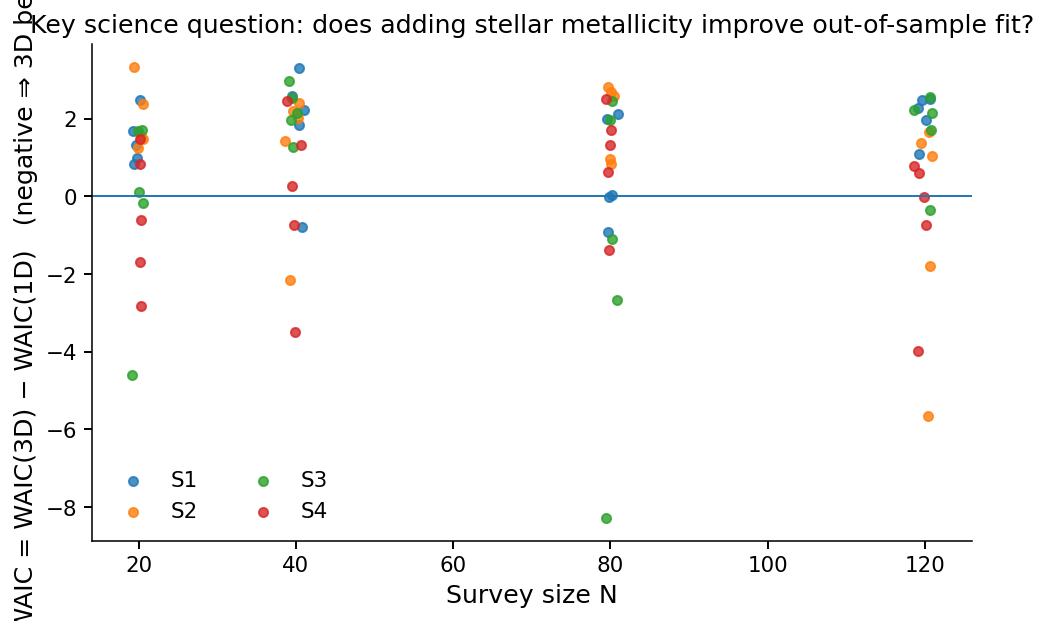

KeyError: 'beta_s_mean'

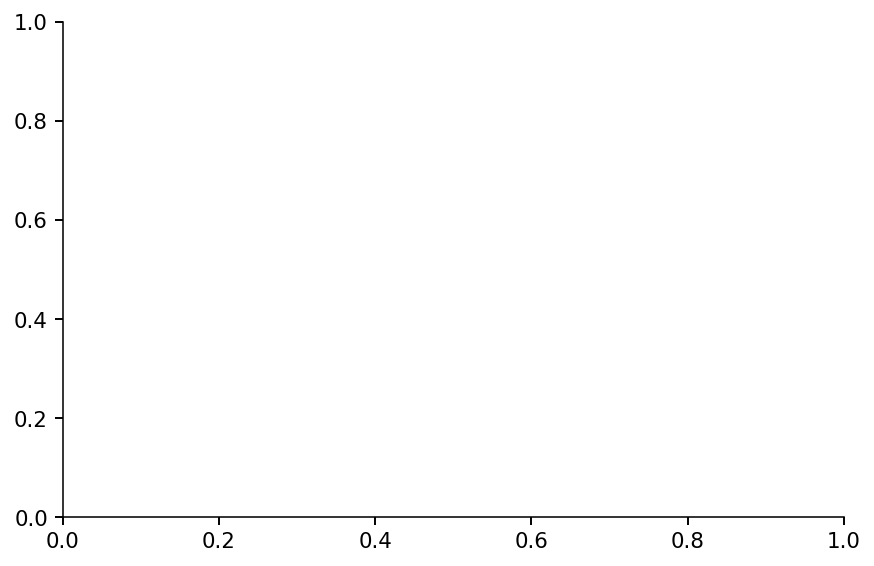

In [8]:
# ===================== PAPER-READY PLOTS (6) + PPC z-score residuals PER SURVEY =====================
# Assumes you already ran the big cell and therefore have:
#   surveys, m1, m3, df1, df3
# and m1/m3 were created with compute_log_lik=True
#
# What this cell does:
#   1) Computes WAIC for 1D and 3D for EVERY survey (same data!)
#   2) Computes ΔWAIC = WAIC_3D - WAIC_1D  (negative => 3D better)
#   3) Computes per-survey PPC z-scores (standardized residuals) for BOTH models
#   4) Produces 6 paper-ready plots + saves per-survey PPC residual plots to PDF

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, arviz as az
import jax, jax.numpy as jnp

# ------------------------------ style ------------------------------
plt.rcParams.update({
    "figure.dpi": 140,
    "savefig.dpi": 300,
    "font.size": 12,
    "axes.labelsize": 13,
    "axes.titlesize": 13,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

OUTDIR = "paper_plots"
PPCDIR = os.path.join(OUTDIR, "ppc_by_survey")
os.makedirs(OUTDIR, exist_ok=True)
os.makedirs(PPCDIR, exist_ok=True)

def _clean_ax(ax):
    ax.grid(False)
    ax.tick_params(direction="out", length=4, width=1)

def _finite(*arrs):
    m = np.ones_like(arrs[0], dtype=bool)
    for a in arrs:
        m &= np.isfinite(a)
    return m

def _et68(x):
    lo, hi = np.quantile(x, [0.16, 0.84])
    return lo, hi

# ------------------------------ helpers: build model kwargs and compute z-scores ------------------------------
def _z_scores_1d(survey, idata):
    df = survey.df
    x = df["logM"].to_numpy(float)
    y = df["log(X_H2O)"].to_numpy(float)
    el = df["uncertainty_lower"].to_numpy(float)
    eh = df["uncertainty_upper"].to_numpy(float)

    m = _finite(x, y, el, eh)
    x, y, el, eh = x[m], y[m], el[m], eh[m]

    meas_sigma = np.clip(0.5*(np.abs(el)+np.abs(eh)), 1e-6, None)
    x_c = x - x.mean()

    post = idata.posterior
    alpha = np.asarray(post["alpha"]).reshape(-1)
    beta  = np.asarray(post["beta"]).reshape(-1)
    eps   = np.asarray(post["epsilon"]).reshape(-1)

    # posterior mean of mu_i across draws
    # mu_draws shape: (S, N)
    mu_draws = alpha[:, None] + beta[:, None]*x_c[None, :]
    mu_mean  = mu_draws.mean(axis=0)

    # use posterior mean epsilon for z-score denominator (stable & interpretable)
    eps_mean = float(eps.mean())
    sig_tot  = np.sqrt(meas_sigma**2 + eps_mean**2)

    z = (y - mu_mean) / sig_tot
    return {
        "x": x, "x_c": x_c, "y": y, "meas_sigma": meas_sigma,
        "mu_mean": mu_mean, "eps_mean": eps_mean, "z": z, "mask_used": m
    }

def _z_scores_3d(survey, idata):
    df = survey.df
    xm = df["logM"].to_numpy(float)
    xs = df["Star Metallicity"].to_numpy(float)
    y  = df["log(X_H2O)"].to_numpy(float)
    elp = df["uncertainty_lower"].to_numpy(float)
    ehp = df["uncertainty_upper"].to_numpy(float)
    els = df["Star Metallicity Error Lower"].to_numpy(float)
    ehs = df["Star Metallicity Error Upper"].to_numpy(float)

    m = _finite(xm, xs, y, elp, ehp, els, ehs)
    xm, xs, y, elp, ehp, els, ehs = xm[m], xs[m], y[m], elp[m], ehp[m], els[m], ehs[m]

    sig_p = np.clip(0.5*(np.abs(elp)+np.abs(ehp)), 1e-6, None)

    xm_c = xm - xm.mean()

    post = idata.posterior
    alpha = np.asarray(post["alpha_p"]).reshape(-1)
    bp    = np.asarray(post["beta_p"]).reshape(-1)
    bs    = np.asarray(post["beta_s"]).reshape(-1)
    eps   = np.asarray(post["epsilon"]).reshape(-1)

    # latent x_s_true is in posterior with shape (chain, draw, N) -> flatten to (S, N)
    x_s_true = np.asarray(post["x_s_true"]).reshape(-1, xs.size)

    # center latent per draw (consistent with your model)
    x_s_true_c = x_s_true - x_s_true.mean(axis=1, keepdims=True)

    mu_draws = alpha[:, None] + bp[:, None]*xm_c[None, :] + bs[:, None]*x_s_true_c
    mu_mean  = mu_draws.mean(axis=0)

    eps_mean = float(eps.mean())
    sig_tot  = np.sqrt(sig_p**2 + eps_mean**2)
    z = (y - mu_mean) / sig_tot

    return {
        "xm": xm, "xm_c": xm_c, "xs": xs, "y": y, "sig_p": sig_p,
        "mu_mean": mu_mean, "eps_mean": eps_mean, "z": z, "mask_used": m,
        "bp_mean": float(bp.mean()), "bs_mean": float(bs.mean())
    }

def _survey_metrics(survey):
    # predictors you asked about
    out = {
        "survey_id": survey.survey_id,
        "class_label": survey.class_label,
        "N": survey.n,
        "L_logM": float(survey.leverage(col="logM")),
        "L_met": float(survey.leverage(col="log(X_H2O)")),
    }
    # optional 3D leverage / Mahalanobis if cols exist
    if "Planet Radius [Re]" in survey.df.columns and "Star Metallicity" in survey.df.columns:
        out["L_3D"] = float(survey.leverage_3D(col_x="logM", col_y="Star Metallicity", col_z="Planet Radius [Re]"))
        out["Mahal_3D"] = float(survey.mahalanobis_3D(col_x="logM", col_y="Star Metallicity", col_z="Planet Radius [Re]"))
    else:
        out["L_3D"] = np.nan
        out["Mahal_3D"] = np.nan
    return out

# ------------------------------ compute WAIC + z-scores for ALL surveys ------------------------------
rows = []
ppc_rows = []

print("Computing per-survey fits (again) for WAIC + PPC z-scores...")
print("Note: This can take a while because it runs BOTH models per survey.")

for s in surveys:
    # fit both models on the SAME survey (same data)
    id1 = m1.fit_survey(s, random_seed=0)
    id3 = m3.fit_survey(s, random_seed=0)

    # WAIC (lower is better)
    w1 = az.waic(id1, var_name="y")
    w3 = az.waic(id3, var_name="y_planet")

    # store model parameter summaries from existing dfs (optional)
    met = _survey_metrics(s)

    # 1D z-scores
    z1 = _z_scores_1d(s, id1)
    # 3D z-scores
    z3 = _z_scores_3d(s, id3)

    # summary residual diagnostics per survey
    def _z_summary(z):
        z = np.asarray(z)
        return {
            "z_mean": float(np.mean(z)),
            "z_sd": float(np.std(z, ddof=1)) if z.size > 1 else np.nan,
            "frac_|z|>2": float(np.mean(np.abs(z) > 2.0)),
            "frac_|z|>3": float(np.mean(np.abs(z) > 3.0)),
            "rmse_z": float(np.sqrt(np.mean(z**2))),
        }

    # ArviZ: WAIC is not provided directly; compute it from elpd_waic
    waic_1d = float(-2.0 * w1.elpd_waic)
    waic_3d = float(-2.0 * w3.elpd_waic)

    met_row = dict(
    **met,

    elpd_waic_1d=float(w1.elpd_waic),
    elpd_waic_3d=float(w3.elpd_waic),
    pwaic_1d=float(w1.p_waic),
    pwaic_3d=float(w3.p_waic),

    waic_1d=waic_1d,
    waic_3d=waic_3d,

    d_elpd_waic=float(w3.elpd_waic - w1.elpd_waic),   # positive => 3D better
    d_waic=float(waic_3d - waic_1d),                  # negative => 3D better
)

    rows.append(met_row)

    ppc_rows.append({
        "survey_id": s.survey_id, "class_label": s.class_label, "N": s.n,
        **{f"1d_{k}": v for k,v in _z_summary(z1["z"]).items()},
        **{f"3d_{k}": v for k,v in _z_summary(z3["z"]).items()},
    })

    # --------- SAVE per-survey PPC residual plots (paper-clean) ----------
    # 2-panel: z vs logM for both models, same y-limits
    fig, axs = plt.subplots(1, 2, figsize=(10.5, 3.6), sharey=True)
    for ax in axs: _clean_ax(ax)

    # 1D
    axs[0].axhline(0, lw=1)
    axs[0].axhline( 2, lw=0.8, ls="--")
    axs[0].axhline(-2, lw=0.8, ls="--")
    axs[0].scatter(z1["x"], z1["z"], s=18, alpha=0.8)
    axs[0].set_title(f"Survey {s.survey_id} • 1D")
    axs[0].set_xlabel("logM")
    axs[0].set_ylabel("PPC z-score  (y - E[y|x]) / σ_total")

    # 3D
    axs[1].axhline(0, lw=1)
    axs[1].axhline( 2, lw=0.8, ls="--")
    axs[1].axhline(-2, lw=0.8, ls="--")
    axs[1].scatter(z3["xm"], z3["z"], s=18, alpha=0.8)
    axs[1].set_title(f"Survey {s.survey_id} • 3D")
    axs[1].set_xlabel("logM")

    # consistent y-limits (robust)
    z_all = np.concatenate([np.asarray(z1["z"]), np.asarray(z3["z"])])
    lim = np.nanquantile(np.abs(z_all), 0.98)
    lim = max(2.5, float(lim))
    axs[0].set_ylim(-lim, lim)

    fig.suptitle(f"PPC residuals (z-scores): class={s.class_label}, N={s.n}", y=1.03)
    fig.tight_layout()
    fig.savefig(os.path.join(PPCDIR, f"ppc_z_survey_{s.survey_id:04d}.pdf"), bbox_inches="tight")
    plt.close(fig)

metrics_df = pd.DataFrame(rows).sort_values(["class_label","N","survey_id"]).reset_index(drop=True)
ppc_df = pd.DataFrame(ppc_rows).sort_values(["class_label","N","survey_id"]).reset_index(drop=True)

print("Computed metrics_df:", metrics_df.shape, " | ppc_df:", ppc_df.shape)
display(metrics_df.head())
display(ppc_df.head())

# ===================== PLOT 1: ΔWAIC vs N (Does 3D help for SAME data?) =====================
fig, ax = plt.subplots(figsize=(7.2, 4.6))
_clean_ax(ax)

# jitter N slightly for visibility
rng = np.random.default_rng(0)
xj = metrics_df["N"].to_numpy(float) + rng.normal(0, 0.6, size=len(metrics_df))

for lab in sorted(metrics_df["class_label"].unique()):
    d = metrics_df[metrics_df["class_label"] == lab]
    x = d["N"].to_numpy(float) + rng.normal(0, 0.6, size=len(d))
    ax.scatter(x, d["d_waic"], s=22, alpha=0.8, label=lab)

ax.axhline(0, lw=1)
ax.set_xlabel("Survey size N")
ax.set_ylabel("ΔWAIC = WAIC(3D) − WAIC(1D)   (negative ⇒ 3D better)")
ax.set_title("Key science question: does adding stellar metallicity improve out-of-sample fit?")
ax.legend(frameon=False, ncols=2)
fig.tight_layout()
fig.savefig(os.path.join(OUTDIR, "plot1_deltaWAIC_vs_N.pdf"), bbox_inches="tight")
plt.show()

# ===================== PLOT 2: Identifiability of beta_s  (|beta_s|/sd) vs N =====================
fig, ax = plt.subplots(figsize=(7.2, 4.6))
_clean_ax(ax)

sig = np.abs(metrics_df["beta_s_mean"]) / np.clip(metrics_df["beta_s_sd"], 1e-12, None)

for lab in sorted(metrics_df["class_label"].unique()):
    d = metrics_df[metrics_df["class_label"] == lab]
    sig_d = np.abs(d["beta_s_mean"]) / np.clip(d["beta_s_sd"], 1e-12, None)
    ax.scatter(d["N"], sig_d, s=22, alpha=0.8, label=lab)

ax.axhline(1, lw=0.9, ls="--")
ax.set_xlabel("Survey size N")
ax.set_ylabel(r"$|\beta_s|/\mathrm{sd}(\beta_s)$  (≈ significance)")
ax.set_title("Is the stellar-metallicity slope actually identified?")
ax.legend(frameon=False, ncols=2)
fig.tight_layout()
fig.savefig(os.path.join(OUTDIR, "plot2_betaS_significance_vs_N.pdf"), bbox_inches="tight")
plt.show()

# ===================== PLOT 3: Posterior mean relation slices (3D model) =====================
# We draw three [Fe/H] slices using posterior means and posterior covariance-free bands via posterior draws.
# Choose three representative stellar metallicities from GLOBAL data percentiles.
xs_all = df["Star Metallicity"].to_numpy(float)
xs_vals = np.quantile(xs_all[np.isfinite(xs_all)], [0.2, 0.5, 0.8])
xs_vals = [float(v) for v in xs_vals]

# Use ONE representative survey (largest N) to show the learned relation cleanly.
s_ref = max(surveys, key=lambda s: s.n)
id3_ref = m3.fit_survey(s_ref, random_seed=1)

post = id3_ref.posterior
alpha = np.asarray(post["alpha_p"]).reshape(-1)
bp    = np.asarray(post["beta_p"]).reshape(-1)
bs    = np.asarray(post["beta_s"]).reshape(-1)
eps   = np.asarray(post["epsilon"]).reshape(-1)

# grid in mass (centered at the reference survey mean mass)
xm_ref = s_ref.df["logM"].to_numpy(float)
m0 = float(np.mean(xm_ref[np.isfinite(xm_ref)]))
m_grid = np.linspace(np.nanmin(xm_ref), np.nanmax(xm_ref), 120)
m_c_grid = m_grid - m0

# For slices, we set x_s_true_c to (xs - mean_xs_true). We approximate mean_xs_true by mean observed in survey.
xs0 = float(np.mean(s_ref.df["Star Metallicity"].to_numpy(float)))

fig, ax = plt.subplots(figsize=(7.2, 4.8))
_clean_ax(ax)

for xs_fix in xs_vals:
    xs_c = xs_fix - xs0
    mu_draws = alpha[:, None] + bp[:, None]*m_c_grid[None, :] + bs[:, None]*xs_c
    mu_mean = mu_draws.mean(axis=0)
    lo, hi = np.quantile(mu_draws, [0.16, 0.84], axis=0)
    ax.plot(m_grid, mu_mean, lw=2, label=f"[Fe/H] ≈ {xs_fix:+.2f}")
    ax.fill_between(m_grid, lo, hi, alpha=0.20)

# overlay the survey points faintly
y_ref = s_ref.df["log(X_H2O)"].to_numpy(float)
ax.scatter(xm_ref, y_ref, s=18, alpha=0.35)

ax.set_xlabel("logM")
ax.set_ylabel(r"Predicted mean log(X_H2O)")
ax.set_title(f"3D model mean relation: mass trends at fixed stellar metallicity (survey {s_ref.survey_id}, N={s_ref.n})")
ax.legend(frameon=False)
fig.tight_layout()
fig.savefig(os.path.join(OUTDIR, "plot3_3D_mean_relation_slices.pdf"), bbox_inches="tight")
plt.show()

# ===================== PLOT 4: PPC residuals summary across surveys (1D vs 3D) =====================
# Show RMSE(z) vs N for BOTH models. (Lower is better; ~1 is well-calibrated.)
fig, ax = plt.subplots(figsize=(7.2, 4.6))
_clean_ax(ax)

for lab in sorted(ppc_df["class_label"].unique()):
    d = ppc_df[ppc_df["class_label"] == lab]
    ax.scatter(d["N"], d["1d_rmse_z"], s=22, alpha=0.75, marker="o", label=f"{lab} 1D")
    ax.scatter(d["N"], d["3d_rmse_z"], s=22, alpha=0.75, marker="^", label=f"{lab} 3D")

ax.axhline(1.0, lw=0.9, ls="--")
ax.set_xlabel("Survey size N")
ax.set_ylabel("RMSE of PPC z-scores (ideal ≈ 1)")
ax.set_title("Predictive calibration: does 3D reduce standardized residuals?")
ax.legend(frameon=False, ncols=2)
fig.tight_layout()
fig.savefig(os.path.join(OUTDIR, "plot4_ppc_rmseZ_vs_N.pdf"), bbox_inches="tight")
plt.show()

# ===================== PLOT 5: ΔWAIC vs 3D leverage metrics (Is leverage predictive?) =====================
# We'll use Mahalanobis_3D if available, else fall back to L_3D (may be NaN if radius not present).
fig, ax = plt.subplots(figsize=(7.2, 4.6))
_clean_ax(ax)

use_x = "Mahal_3D" if np.isfinite(metrics_df["Mahal_3D"]).any() else "L_3D"
d = metrics_df[np.isfinite(metrics_df[use_x])].copy()

if d.empty:
    print("PLOT 5 skipped: No 3D leverage columns available (need Star Metallicity + Planet Radius [Re]).")
else:
    for lab in sorted(d["class_label"].unique()):
        dd = d[d["class_label"] == lab]
        ax.scatter(dd[use_x], dd["d_waic"], s=22, alpha=0.8, label=lab)
    ax.axhline(0, lw=1)
    ax.set_xlabel(use_x)
    ax.set_ylabel("ΔWAIC = WAIC(3D) − WAIC(1D)   (negative ⇒ 3D better)")
    ax.set_title("Is 3D leverage a predictor of when the 3D model helps?")
    ax.legend(frameon=False, ncols=2)
    fig.tight_layout()
    fig.savefig(os.path.join(OUTDIR, f"plot5_deltaWAIC_vs_{use_x}.pdf"), bbox_inches="tight")
    plt.show()

# ===================== PLOT 6: Joint posterior (beta_p vs beta_s) =====================
# Use the same reference survey posterior as Plot 3 (cleanest).
bp_s = np.asarray(id3_ref.posterior["beta_p"]).reshape(-1)
bs_s = np.asarray(id3_ref.posterior["beta_s"]).reshape(-1)

fig, ax = plt.subplots(figsize=(5.8, 5.4))
_clean_ax(ax)

ax.scatter(bp_s[::max(1, bp_s.size//4000)], bs_s[::max(1, bs_s.size//4000)], s=10, alpha=0.25)
ax.set_xlabel(r"$\beta_p$  (mass slope)")
ax.set_ylabel(r"$\beta_s$  (stellar metallicity slope)")
ax.set_title(f"Joint posterior: β_p vs β_s (survey {s_ref.survey_id}, N={s_ref.n})")

# show 68% intervals as lines
bp_lo, bp_hi = _et68(bp_s)
bs_lo, bs_hi = _et68(bs_s)
ax.axvline(bp_lo, lw=0.9, ls="--"); ax.axvline(bp_hi, lw=0.9, ls="--")
ax.axhline(bs_lo, lw=0.9, ls="--"); ax.axhline(bs_hi, lw=0.9, ls="--")

fig.tight_layout()
fig.savefig(os.path.join(OUTDIR, "plot6_jointposterior_betaP_betaS.pdf"), bbox_inches="tight")
plt.show()

# ===================== (Extra) A single “answer plot”: ΔWAIC vs L_logM (Is 1D leverage enough?) =====================
# This directly tests: is leverage even a good predictor? (your existing metric)
fig, ax = plt.subplots(figsize=(7.2, 4.6))
_clean_ax(ax)
for lab in sorted(metrics_df["class_label"].unique()):
    dd = metrics_df[metrics_df["class_label"] == lab]
    ax.scatter(dd["L_logM"], dd["d_waic"], s=22, alpha=0.8, label=lab)
ax.axhline(0, lw=1)
ax.set_xlabel("1D leverage L_logM")
ax.set_ylabel("ΔWAIC = WAIC(3D) − WAIC(1D)   (negative ⇒ 3D better)")
ax.set_title("Is 1D leverage sufficient to predict when 3D helps?")
ax.legend(frameon=False, ncols=2)
fig.tight_layout()
fig.savefig(os.path.join(OUTDIR, "extra_deltaWAIC_vs_LlogM.pdf"), bbox_inches="tight")
plt.show()

print("\nSaved:")
print(" - 6 paper plots to:", OUTDIR)
print(" - per-survey PPC residual PDFs to:", PPCDIR)
print("\nKey science read-off:")
print(" - Plot 1 (ΔWAIC vs N): if points are mostly >0 → 3D not justified; mostly <0 → 3D helps.")
print(" - Plot 5 (ΔWAIC vs 3D leverage): correlation → leverage predicts when 3D helps; no trend → leverage not enough.")
print(" - PPC per-survey PDFs: look for structure in z vs logM; persistent structure means model misspecification.")
